In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis


In [2]:

# 默认参数
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # 为了让两个网络的rho相等
print(num_g)
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25


# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)

def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg


20


In [3]:
Ap = 1.0084058
Rp = 0.0128615275
Ag = 0.9814125
Rg = 0.013212965

def Grid_tuning_generation(phi_candidate, a_g, num_g):
    # phi_candidate shape: [M, n_candidate]
    n_candidate = phi_candidate.shape[-1]
    theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)  # Assuming theta is linspace
    
    # Broadcasting phi_candidate to shape [M, 1, n_candidate]
    phi_candidate_expanded = phi_candidate[:, np.newaxis, :]
    
    # Calculate dis_theta using broadcasting
    dis_theta = circ_dis(theta[:, np.newaxis], phi_candidate_expanded)
    
    # Calculate fg_prime using broadcasting
    a_g_expanded = a_g[:, np.newaxis, np.newaxis]
    fg_prime = np.exp(-dis_theta ** 2 / (4 * a_g_expanded ** 2))
    
    return fg_prime



def loglikelihood_Ig(Ig, fg, sigma_g):
    n_phi = fg.shape[-1]
    # 使用 expand_dims 将矩阵扩展为 (n, m, 1)
    Ig_expand = np.expand_dims(Ig, axis=-1)
    # 使用 tile 将矩阵沿最后一个轴重复 K 次
    Ig_expand = np.tile(Ig_expand, (1, 1, n_phi))
    log_prob = -0.5 * (Ig_expand - fg)**2 / sigma_g[:,None,None]**2 # shape [M, n_g, n_phi]
    log_prob = np.sum(log_prob, axis=1) 
    return log_prob # shape [M, n_phi]

def mapping_func(x):
    lambda_gs = Lambda
    phi = x[:,None] % Lambda *np.pi*2/Lambda
    return phi # [n_pos, M]

def prior_function(phi, z_candidates, sigma_phi):
    '''
    P(phi | x), phi shape [M], phi_x is a scalar
    '''
    phi_x = mapping_func(z_candidates) # shape [n_pos, M]
    kappa_phi = 1 / (sigma_phi)**2
    log_prob = kappa_phi*np.cos(phi-phi_x) # shape [n_pos, M]
    log_prob_z = np.sum(log_prob, axis=1)
    return log_prob_z # shape [M]

def Simplified_PSC_MAP_decoder(activation_gs, n_pos=4000, n_phi=100, M=3, 
                               alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag):  
    '''
    MAP: Maximum A Posteriori
    activation_gs shape [M, n_g]
    '''
    sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
    sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
    sigma_g_infer = sigma_g * noise_ratio
    sigma_phi_infer = sigma_phi * noise_ratio
    
    L_env = 60
    ## parameter space
    z_candidates = np.linspace(0, L_env, n_pos)
    
    phi_candidates = np.linspace(0, 2*np.pi, n_phi, endpoint=False)
    phi_candidates_modules = np.tile(phi_candidates[:, np.newaxis], (1, M))
    phi_candidates_modules = phi_candidates_modules.T
    fg_modules = Grid_tuning_generation(phi_candidates_modules,a_g,num_g) # shape [M, n_g, n_phi]

    log_likelihood_fr = loglikelihood_Ig(activation_gs, fg_modules, sigma_g=sigma_g_infer) # shape [M, n_phi]
    phi_decode_index = np.argmax(log_likelihood_fr, axis=1)

    phi_decode = phi_candidates[phi_decode_index]
    # Second step: decode z
    prior = prior_function(phi_decode, z_candidates, sigma_phi=sigma_phi_infer)
    # plt.plot(prior)
    z_est_index = np.argmax(prior)
    z_decode = z_candidates[z_est_index]
    return z_decode, phi_decode

In [4]:
sigma_g = np.sqrt(np.sqrt(np.pi)*Ag**3*rho_g*tau_g/(a_g*alpha_g)) * 0.01
sigma_phi = np.sqrt(8*np.pi*Ag*tau_g/(Lambda*J_pg*rho_p*Rp)) * 0.01
sigma_p = np.sqrt(np.sqrt(np.pi)*Ap**3*rho_p*tau_p/(a_p*alpha_p)) * 0.01
print(sigma_g, sigma_p, sigma_phi)

[0.19295613 0.19295613 0.19295613] 0.2009713795376621 [0.22407002 0.16805252 0.13444201]


In [5]:
c = 0.1  # 对角线以外的位置的常数
# 生成一个全为c的矩阵
Sigma_G = np.full((num_g, num_g), c)
Sigma_P = np.full((num_p, num_p), c)
np.fill_diagonal(Sigma_G, 1)
np.fill_diagonal(Sigma_P, 1)
Lg = np.linalg.cholesky(Sigma_G)
Lp = np.linalg.cholesky(Sigma_P)

100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


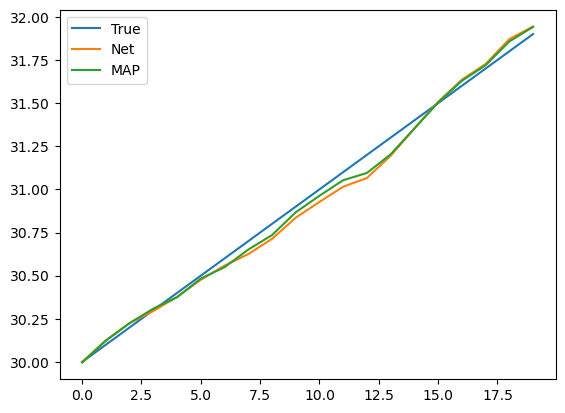

In [6]:
import numpy as bm
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm
from utils_funcs import *
from tqdm import tqdm
import jax.numpy as jbm
import numpy as np


# 默认参数
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = bm.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * bm.pi)  # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = bm.linspace(0, L, num_p, endpoint=False)
theta = bm.linspace(0, 2 * bm.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * bm.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25


# divisive normalization
k_p = 20.
k_g = Lambda / 2 / bm.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * bm.pi * tau_p / Lambda
# ibmut_strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)



def Path_integration_decoding(z0, phi_0, step_size=0.1, step_num=20, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    #Initial net 
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
    # 初始化网络
    T_init = 1000
    fg = bm.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = bm.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = bm.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = bm.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = bm.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0
    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)

    
    # Network decoding
    # run network dynamics to decode
    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        Ar_p = bm.max(rp)
        Au_p = bm.max(up)
        Ar_g = bm.max(rg, axis=1)
        Au_g = bm.max(ug, axis=1)
        return z_decode, phi_decode, Ar_p, Au_p, Ar_g, Au_g


    # 路径积分
    T = 1000 # 为了稳定下来的固定时长
    indices = bm.arange(T)
    # 初始化
    z_net_time = np.zeros(step_num)
    phi_net_time = np.zeros((M,step_num))
    z_MAP_time = np.zeros(step_num)
    phi_MAP_time = np.zeros((M,step_num))

    Ig_map = alpha_g * fg #initial grid input for MAP and NEt
    I_grid = bm.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    Ip = 0 * bm.exp(-dis_x ** 2 / (4 * a_p ** 2)) 
    I_place = bm.repeat(Ip[np.newaxis, :], T, axis=0) #initial place input for MAP and NEt

    # for i in range(step_num):
    for i in tqdm(range(step_num), leave=True):
        # Net decoding
        z_record, phi_record, Ar_p, Au_p, _, Au_g = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)
        z_net_time[i] = z_record[-1][0]
        phi_net_time[:,i] = phi_record[-1]

        # MAP decoding
        Ap = Au_p[-1]
        Rp = Ar_p[-1]
        Ag = Au_g[-1,:]
        z_decode_map, phi_decode_map = Simplified_PSC_MAP_decoder(activation_gs=Ig_map, Ap=Ap, Rp=Rp, Ag=Ag)
        z_MAP_time[i] = z_decode_map
        phi_MAP_time[:,i] = phi_decode_map

        # Step change
        dpsi = step_size / Lambda * 2 * bm.pi + sigma_phi * bm.random.randn(M) 

        # Path integration for net (path integration process is indepent for Net and MAP)
        psi_net = Coupled_model.phase + bm.pi # bump center of grid cells
        psi_net += dpsi # path integration
        psi_net = bm.mod(psi_net, 2 * bm.pi)
        Ig_net = bm.zeros((M, num_g))  # input is different for net and map
        noise_g = bm.zeros((M, num_g)) # noise is the same for net and map
        for j in range(M):
            dis_theta = circ_dis(theta, psi_net[j])
            noise_g[j, :] = neural_noise_sigma * bm.random.randn(num_g)
            Ig_net[j, :] = bm.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2))
        Ig_net += noise_g
        I_grid = alpha_g * bm.repeat(Ig_net[np.newaxis, :, :], T, axis=0)

        # Path integration for MAP (path integration process is indepent for Net and MAP)
        psi_map = phi_decode_map
        psi_map += dpsi
        psi_map = bm.mod(psi_map, 2 * bm.pi)
        Ig_map = bm.zeros((M, num_g))
        for j in range(M):
            dis_theta = circ_dis(theta, psi_map[j])
            Ig_map[j, :] = bm.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2))
        Ig_map += noise_g
    return z_net_time, phi_net_time, z_MAP_time, phi_MAP_time

# 测试运行，只跑一个trial
z_truth = 30
phi_truth = bm.mod(z_truth / Lambda, 1) * 2 * bm.pi 
neural_noise_sigma = 0.15 # Fixed noise sigma value
sigma_phi = bm.array([31.7, 23.8, 19]) * neural_noise_sigma * 0.01
step_size = 0.1
step_num = 20

z_net_time, phi_net_time, z_decode_MAP, phi_decode_MAP = Path_integration_decoding(z0=z_truth, phi_0 = phi_truth, Coupled_model=Coupled_model)
z_ture = np.ones(step_num) * z_truth + np.arange(step_num) * step_size
plt.plot(z_ture, label='True')
plt.plot(z_net_time, label='Net')
plt.plot(z_decode_MAP, label='MAP')
plt.legend()
plt.show()

In [7]:
# 仿真参数
trial_num = 1000
z_truth = 30
step_num = 20
step_size = 0.1
z_true = np.ones(step_num) * z_truth + np.arange(step_num) * step_size
phi_truth = bm.mod(z_truth / Lambda, 1) * 2 * bm.pi 
neural_noise_sigma = 0.15 # Fixed noise sigma value
sigma_phi = bm.array([31.7, 23.8, 19]) * neural_noise_sigma * 0.01

z_decode_MAP_trials = bm.zeros((step_num, trial_num))
z_decode_net_trials = bm.zeros((step_num, trial_num))

In [ ]:
from tqdm import tqdm

# 正式运行
for i in tqdm(range(trial_num), leave=True):
    z_net_time, phi_net_time, z_decode_MAP, phi_decode_MAP = Path_integration_decoding(z0=z_truth, phi_0 = phi_truth, Coupled_model=Coupled_model)

    for t_idx in tqdm(range(step_num), leave=True):
        z_decode_MAP_trials[t_idx, i] = z_decode_MAP[t_idx]
        z_decode_net_trials[t_idx, i] = z_net_time[t_idx]

error_MAP_time = bm.zeros(step_num)
error_net_time = bm.zeros(step_num)

for t_idx in tqdm(range(step_num), leave=True):
    z = z_true[t_idx]
    error_MAP_time[t_idx] = np.mean(np.abs(z_decode_MAP_trials[t_idx] - z))
    error_net_time[t_idx] = np.mean(np.abs(z_decode_net_trials[t_idx] - z))

# # 保存数据为npz文件
# np.savez('data/MAP_vs_Net_comparison_dynamic_time_sigma0.15_step20_trial_num1000.npz', 
#          error_MAP_time=error_MAP_time, 
#          error_net_time=error_net_time, 
#          z_decode_MAP_trials=z_decode_MAP_trials, 
#          z_decode_net_trials=z_decode_net_trials)

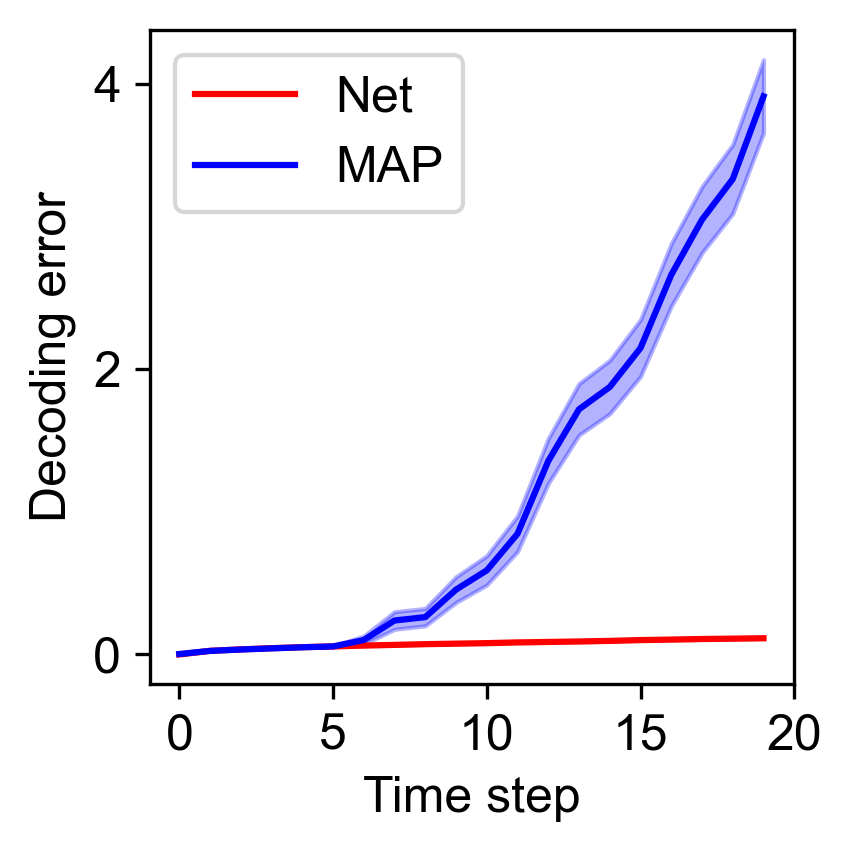

In [10]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('data/MAP_vs_Net_comparison_dynamic_time_sigma0.15_step20_trial_num1000.npz')
error_MAP_time = data['error_MAP_time']
error_net_time = data['error_net_time']
z_decode_MAP_trials = data['z_decode_MAP_trials']
z_decode_net_trials = data['z_decode_net_trials']

# Calculate standard error for error bars
std_error_MAP_time = np.std(np.abs(z_decode_MAP_trials - z_true[:, None]), axis=1) / np.sqrt(trial_num)
std_error_net_time = np.std(np.abs(z_decode_net_trials - z_true[:, None]), axis=1) / np.sqrt(trial_num)

plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
plt.figure(figsize=(3,3),dpi=300)

plt.plot(range(step_num), error_net_time, label='Net', color='red', linewidth=1.5)
plt.fill_between(range(step_num), error_net_time - std_error_net_time, error_net_time + std_error_net_time, color='red', alpha=0.3)

plt.plot(range(step_num), error_MAP_time, label='MAP', color='blue', linewidth=1.5)
plt.fill_between(range(step_num), error_MAP_time - std_error_MAP_time, error_MAP_time + std_error_MAP_time, color='blue', alpha=0.3)

plt.xlabel('Time step')
plt.ylabel('Decoding error')
plt.legend()
plt.grid(False)

# 标记sigma大小
# plt.title(f'Decoding Error vs Time Steps (sigma={neural_noise_sigma})')
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 2, 4], ['0', '2', '4'])
plt.tight_layout()
neural_noise_sigma = 0.15
plt.savefig(f'figure/net_decoding_time_sigma{neural_noise_sigma}_trial_1k.pdf')
plt.show()